# Classification


In [1]:
%load_ext lab_black

In [2]:
from gpjax import RBF
from gpjax.likelihoods import Bernoulli
from gpjax.gps import Prior
import jax.numpy as jnp
import matplotlib.pyplot as plt
import jax.random as jr
from jax.scipy.special import erf
import tensorflow_probability.substrates.jax as tfp
import objax

key = jr.PRNGKey(123)
tfd = tfp.distributions

## Datasets

We'll simulate a binary dataset where our inputs $x$ are sampled according to $x_i \sim \mathcal{U}(-1., 1.)$ for $1 \leq i \leq 100$. Our corresponding outputs will be calculated according to
$$ y_i = 0.5*\operatorname{sign}(\cos(2*x + \epsilon_i) + 0.5, $$
where $\epsilon_i \sim \mathcal{N}(0, 0.01)$. Note, the multiplication and addition of 0.5 is simply to ensure that our outputs are in $\{0, 1\}$.

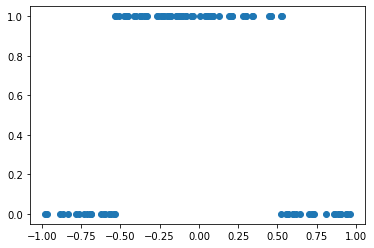

In [3]:
x = jnp.sort(jr.uniform(key, shape=(100, 1), minval=-1.0, maxval=1.0), axis=0)
y = 0.5 * jnp.sign(jnp.cos(3 * x + jr.normal(key, shape=x.shape) * 0.05)) + 0.5
xtest = jnp.linspace(-1.05, 1.05, 500).reshape(-1, 1)
plt.plot(x, y, "o")

We can now define our prior Gaussian process such that an RBF kernel has been selected for the purpose of exposition. However, an alternative kernel may be a better choice.

In [4]:
kern = RBF()
prior = Prior(kern)

To visualise the effect of selecting an RBF kernel and zero-mean function, we can draw a set of samples from the GP prior at our test locations.

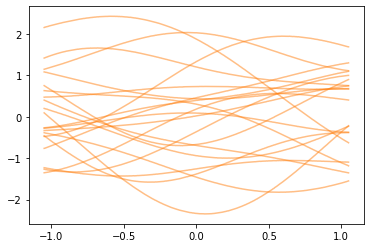

In [5]:
samples = prior.sample(xtest, key, 20).T
plt.plot(xtest, samples, color="tab:orange", alpha=0.5)

Now we can proceed to define our likelihood function. In this example, our observations are binary, so we will select a Bernoulli likelihood. Using this likelihood function, we can compute the posterior through the product of our likelihood and prior.

In [6]:
posterior = prior * Bernoulli()
posterior.marginal_ll(x, y)

DeviceArray(-161.20856981, dtype=float64)

With a posterior in place, we can estimate the maximum a posteriori using ObJax's optimisers. However, our Gaussian process is no longer conjugate, meaning that in addition to the kernel's hyperparameters, we are also tasked with learning the values of process' latent function.

In [7]:
opt = objax.optimizer.Adam(posterior.vars())
gv = objax.GradValues(posterior.neg_mll, posterior.vars())


def train_op(x, label):
    g, v = gv(x, label)
    opt(0.01, g)
    return v


train_op = objax.Jit(train_op, gv.vars() + opt.vars())

In [8]:
nits = 500
loss = [train_op(x, y)[0].item() for _ in range(nits)]

Let us now visualise our optimisation procedure by plotting the increasing marginal log-likelihood value.

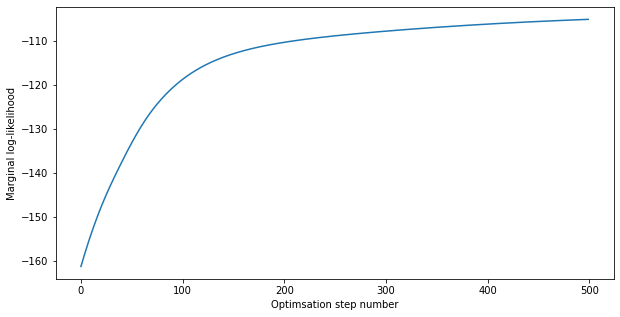

In [9]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot([-l for l in loss])
ax.set_ylabel("Marginal log-likelihood")
ax.set_xlabel("Optimsation step number")

Content that our optimisation has stabilised, we can proceed now to compute the process' predictive mean and predictive variance.

In [10]:
mu, cov = posterior.predict(xtest, x, y)

With the first and centralised second moment computed, we can plot these with the original data overlayed to confirm that our process has done a good job of recovering the latent function.

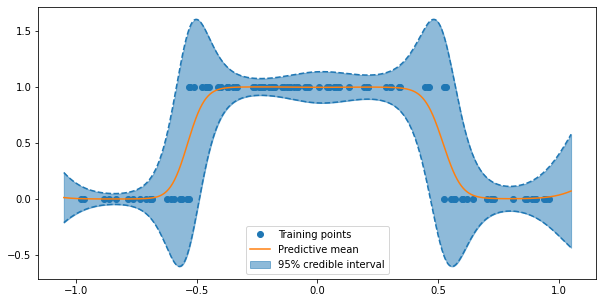

In [11]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(x, y, "o", label="Training points")
ax.plot(xtest, mu, label="Predictive mean", color="tab:orange")
ax.fill_between(
    xtest.ravel(),
    mu.squeeze() - 1.96 * jnp.sqrt(cov),
    mu.squeeze() + 1.96 * jnp.sqrt(cov),
    alpha=0.5,
    label="95% credible interval",
    color="tab:blue",
)
ax.plot(xtest, mu + 1.96 * jnp.sqrt(cov), color="tab:blue", linestyle="--")
ax.plot(xtest, mu - 1.96 * jnp.sqrt(cov), color="tab:blue", linestyle="--")
ax.legend(loc="best")
# plt.savefig("predictive_posterior.png")